In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

#1. Data Collection and Pre-processing
# Load data (replace with your actual file names)
df = pd.read_csv('PANICLE ALL 2.csv')

# Creating a DataFrame from the numpy array #splitting the dataset
X = df.drop(columns=['SPAD'])  # Drop 'sample_id' and 'SPAD' to get the features
y = df['SPAD']  # Target variable

# Check for missing values
print(df.isnull().sum())


500.075    0
500.336    0
500.597    0
500.858    0
501.119    0
          ..
950.048    0
950.286    0
950.524    0
950.763    0
SPAD       0
Length: 1793, dtype: int64


In [2]:
#Explore data statistics
df.describe()

500.075    500.336    500.597    500.858    501.119    501.381  \
count  81.000000  81.000000  81.000000  81.000000  81.000000  81.000000   
mean    4.628025   4.740288   4.776872   4.778196   4.701488   4.737572   
std     0.551927   0.563607   0.566795   0.570103   0.564617   0.569699   
min     3.426667   3.523333   3.513333   3.456667   3.366667   3.393333   
25%     4.245000   4.340000   4.334444   4.340000   4.291111   4.307778   
50%     4.670000   4.758889   4.790000   4.783333   4.732222   4.771111   
75%     4.973333   5.133333   5.160000   5.136667   5.010000   5.064444   
max     6.423333   6.723333   6.830000   6.823333   6.563333   6.623333   

         501.642    501.903    502.164    502.425  ...    948.856    949.094  \
count  81.000000  81.000000  81.000000  81.000000  ...  81.000000  81.000000   
mean    4.823285   4.847202   4.800055   4.843909  ...  33.125658  32.724156   
std     0.577558   0.583951   0.584569   0.589872  ...   4.308998   4.550170   
min     3.450000   3.486667   3.426667   3.483333  ...  23.830000  23.130000   
25%     4.402222   4.420000   4.380000   4.415000  ...  30.255000  29.276667   
50%     4.838889   4.863333   4.836667   4.890000  ...  33.273333  33.075000   
75%     5.156667   5.186667   5.143333   5.210000  ...  36.757778  36.793333   
max     6.813333   6.846667   6.703333   6.793333  ...  40.026667  39.926667   

         949.333    949.571    949.809    950.048    950.286    950.524  \
count  81.000000  81.000000  81.000000  81.000000  81.000000  81.000000   
mean   32.820741  33.107949  32.948203  32.605562  32.611852  32.672716   
std     4.471129   4.298406   4.373473   4.634983   4.641574   4.581399   
min    23.283333  23.766667  23.576667  22.966667  22.913333  22.960000   
25%    29.600000  30.310000  30.020000  29.125000  29.050000  29.345000   
50%    33.096667  33.118889  33.073333  32.970000  32.880000  32.960000   
75%    36.748889  36.788889  36.743333  36.741111  36.777778  36.821111   
max    39.927778  39.937778  39.871111  39.838889  39.844444  39.835556   

         950.763       SPAD  
count  81.000000  81.000000  
mean   32.522462  34.975432  
std     4.729095   4.859557  
min    22.700000  21.900000  
25%    28.866667  32.200000  
50%    32.890000  34.300000  
75%    36.810000  39.370000  
max    39.886667  42.630000  

[8 rows x 1793 columns]

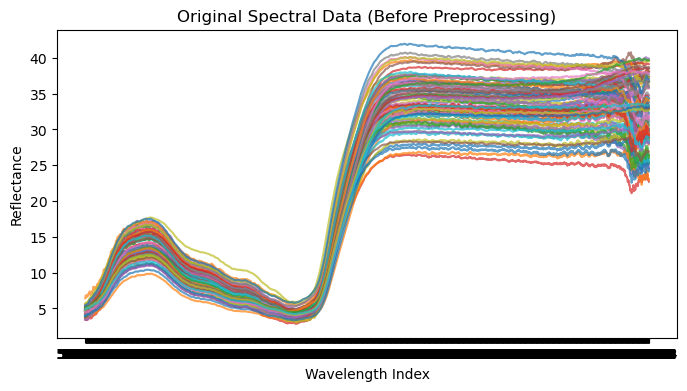

In [3]:
# Plot original spectral data (before preprocessing)
plt.figure(figsize=(8, 4))
plt.plot(X.T, alpha=0.7)
plt.title('Original Spectral Data (Before Preprocessing)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

In [4]:
# Step 1: Calculate Q1, Q3, and IQR for the spectral data
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Step 2: Identify outliers in the spectral data
outliers = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Step 3: Create a mask to identify rows with any outliers
outlier_mask = outliers.any(axis=1)

# Step 4: Calculate the absolute deviation from the IQR boundaries for ranking
deviation = np.maximum((Q1 - X).abs(), (X - Q3).abs())

# Apply the mask to get deviations only for the identified outliers
deviation = deviation[outlier_mask]

# Step 5: Sum deviations across features for each sample (to rank overall extremeness)
total_deviation = deviation.sum(axis=1)

# Step 6: Calculate the maximum number of outliers to remove (5% of the total data)
num_samples = len(X)
max_outliers_to_remove = int(0.05 * num_samples)

# Get indices of the top 5% most extreme outliers
top_outlier_indices = total_deviation.nlargest(max_outliers_to_remove).index

# Create a new outlier mask based on the top 5% of deviations
final_outlier_mask = pd.Series(False, index=X.index)
final_outlier_mask.loc[top_outlier_indices] = True

# Step 7: Remove the top 5% most extreme outliers
cleaned_spectral_data = X[~final_outlier_mask]
cleaned_spad_data = y[~final_outlier_mask]

# Step 8: Combine the cleaned spectral data and SPAD values back into a single DataFrame (if needed)
cleaned_df = pd.concat([cleaned_spectral_data, cleaned_spad_data], axis=1)

# Step 9: Display the results
print(f"Original dataset size: {X.shape[0]}")
print(f"Number of outliers removed: {final_outlier_mask.sum()}")
print(f"Cleaned dataset size: {cleaned_df.shape[0]}")
print(f"Cleaned spectral data size: {cleaned_spectral_data.shape[0]}")

Original dataset size: 81
Number of outliers removed: 4
Cleaned dataset size: 77
Cleaned spectral data size: 77


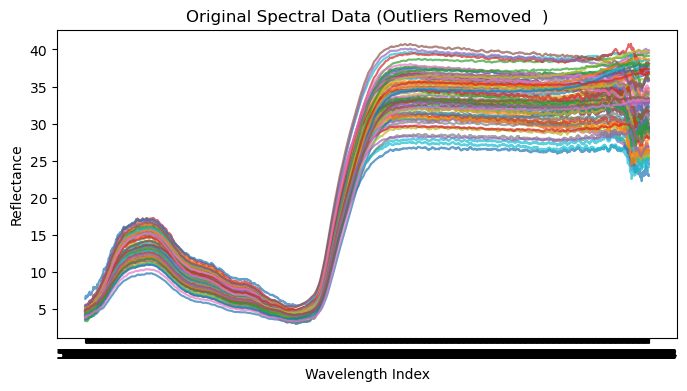

In [5]:
# Plot original spectral data (before preprocessing)
plt.figure(figsize=(8, 4))
plt.plot(cleaned_spectral_data.T,alpha=0.7)
plt.title('Original Spectral Data (Outliers Removed  )')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

Correlation values with SPAD:
500.075    0.091563
500.336   -0.000513
500.597   -0.017370
500.858   -0.008497
501.119    0.088456
             ...   
949.809    0.629376
950.048    0.626711
950.286    0.623613
950.524    0.626196
950.763    0.625117
Name: SPAD, Length: 1792, dtype: float64
Top features correlated with SPAD:
945.755    0.677936
945.517    0.672368
944.323    0.672178
945.994    0.670592
944.8      0.670490
945.039    0.669640
944.562    0.669158
945.278    0.668332
944.084    0.668206
946.232    0.662559
Name: SPAD, dtype: float64


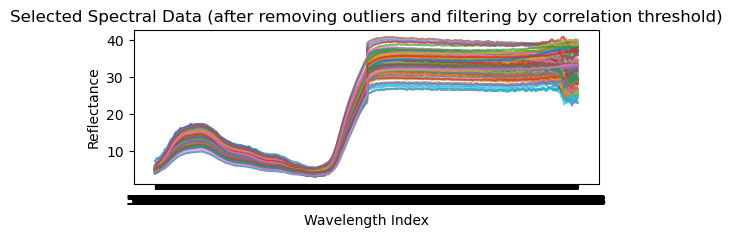

In [6]:
# Step 2: Calculate the correlation matrix for the combined DataFrame
correlation_matrix = cleaned_df.corr()

# Step 3: Extract correlations with the SPAD column (assuming the SPAD column is named 'SPAD')
correlations_with_spad = correlation_matrix['SPAD'].drop('SPAD')

# Step 4: Display the correlation values
print("Correlation values with SPAD:")
print(correlations_with_spad)

# Step 5: Sort correlations by absolute value to find strongest relationships
sorted_correlations = correlations_with_spad.abs().sort_values(ascending=False)
print("Top features correlated with SPAD:")
print(sorted_correlations.head(10))

# Step 6: Set a correlation threshold for feature selection
threshold = 0.1
mask = correlations_with_spad.abs() > threshold

# Step 7: Select features with a correlation higher than the threshold
selected_features = correlations_with_spad[mask].index
X_selected = cleaned_spectral_data[selected_features]

# Step 8: Plot the selected features from the cleaned spectral data
plt.figure(figsize=(6, 2))
plt.plot(X_selected.T, alpha=0.7)
plt.title('Selected Spectral Data (after removing outliers and filtering by correlation threshold)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()


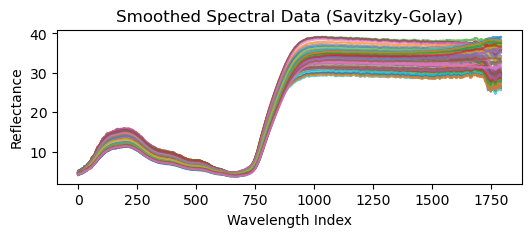

In [7]:
# Function to apply Savitzky-Golay smoothing
def savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2):
    return savgol_filter(cleaned_spectral_data, window_size, poly_order, axis=0)

# Apply Savitzky-Golay smoothing to X_selected
spectral_sgm = savitzky_golay(cleaned_spectral_data, window_size=11, poly_order=2)

#Plot the smoothed spectral data
plt.figure(figsize=(6, 2))
plt.plot(spectral_sgm.T, alpha=0.7)  # Transpose for better plotting
plt.title('Smoothed Spectral Data (Savitzky-Golay)')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.show()

In [8]:
#. Normalization and standardization
# Normalize spectral data
#normalizer = MinMaxScaler()
#spectral_normalized = normalizer.fit_transform(spectral_sgm)

#from sklearn.preprocessing import StandardScaler
# Then standardize
#scaler = StandardScaler()
#spectral_standardized = scaler.fit_transform(spectral_sgm)


In [9]:
# Apply PCA to determine the number of components to retain 95% variance
#pca = PCA()
#X_train_pca = pca.fit_transform(spectral_sgm)
#X_test_pca = pca.transform(spectral_sgm)
#explained_variance_ratio = pca.explained_variance_ratio_
#cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Scree plot
#plt.figure(figsize=(8, 4))
#plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual explained variance')
#plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative explained variance')
#plt.xlabel('Number of Principal Components')
#plt.ylabel('Explained Variance Ratio')
#plt.legend()
#plt.title('Scree Plot')
#plt.grid(True)
#plt.show()

# Choose number of components to retain 95% variance
#n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
#print(f"Number of components to retain 95% variance: {n_components}")

In [10]:
#from sklearn.decomposition import FastICA
from sklearn.decomposition import FastICA
#Assume spectral_sgm is your input data after preprocessing
ica = FastICA(n_components=5, max_iter=500, tol=0.01, random_state=175)

# Apply ICA to the spectral data
X_ica = ica.fit_transform(spectral_sgm)

# Check the shape of the transformed data
print(f"Shape of ICA-transformed data: {X_ica.shape}")


Shape of ICA-transformed data: (77, 5)


In [11]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ica,cleaned_spad_data, test_size=0.25, random_state=175)

In [12]:
from scipy.stats import pearsonr
import numpy as np

# Pearson Correlation for Feature Selection
def select_features_pearson(X_train, y_train, threshold=0.1):
    # Calculate Pearson correlation for each feature in X_train with y_train
    correlations = np.array([pearsonr(X_train[:, i], y_train)[0] for i in range(X_train.shape[1])])
    
    # Select indices of features with absolute correlation greater than threshold
    selected_features = np.where(np.abs(correlations) > threshold)[0]
    
    # Return the filtered training set and the indices of selected features
    return X_train[:, selected_features], selected_features

# Apply Pearson Correlation for Feature Selection
threshold = 0.1  # Adjust the threshold as needed
X_train_pearson, selected_features = select_features_pearson(X_train, y_train, threshold)

# Apply the same feature selection to X_test
X_test_pearson = X_test[:, selected_features]

# Output
print(f"Number of features selected by Pearson correlation: {len(selected_features)}")
print("Selected features indices (Pearson):", selected_features)


Number of features selected by Pearson correlation: 5
Selected features indices (Pearson): [0 1 2 3 4]


In [27]:
# Define parameter grids for RandomizedSearchCV
param_dist_rf = {
   'n_estimators': [900,300,700,200],
    'max_depth': [1,5,8,15],
    'min_samples_split': [2,4,6,8,10],
    'min_samples_leaf': [1,3,5,6,7],
    'bootstrap': [True, False]
}
# Initialize models
model_rf = RandomForestRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_rf = RandomizedSearchCV(model_rf, param_distributions=param_dist_rf, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_rf.fit(X_train_pearson, y_train)
best_rf = random_search_rf.best_estimator_
best_params_rf = random_search_rf.best_params_
print("Best parameters for Random Forest: ", best_params_rf)
# Cross-validation with the best hyperparameters for each model
mse_scores_rf = cross_val_score(best_rf, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_rf = -mse_scores_rf
average_mse_rf = np.mean(mse_scores_rf)

# Print cross-validation results
print(f"Average MSE for Random Forest: {average_mse_rf}")

# Evaluate the individual models
models = {
    "RandomForest": best_rf
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Random Forest:  {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 5, 'bootstrap': True}
Average MSE for Random Forest: 9.845479658188617
Evaluating RandomForest model...
Training Metrics:
                   MAE      MSE  Pearson        R2      RMSE       RPD
RandomForest  1.302187  3.04758  0.94165  0.863569  1.745732  2.707345

Testing Metrics:
                   MAE        MSE  Pearson        R2     RMSE       RPD
RandomForest  2.375605  11.609559  0.75708  0.556183  3.40728  1.501061


In [41]:
# Define parameter grids for RandomizedSearchCV
param_dist_xgb = {
    'n_estimators': [100,20,30,50],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 9, 12],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.9, 1.0]
}
# Initialize models
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=175)
# Perform RandomizedSearchCV for each model
random_search_xgb = RandomizedSearchCV(model_xgb, param_distributions=param_dist_xgb, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_xgb.fit(X_train_pearson, y_train)
best_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_
print("Best parameters for XGBoost: ", best_params_xgb)
# Cross-validation with the best hyperparameters for each model
mse_scores_xgb = cross_val_score(best_xgb, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_xgb = -mse_scores_xgb
average_mse_xgb = np.mean(mse_scores_xgb)
# Print cross-validation results
print(f"Average MSE for XGBoost: {average_mse_xgb}")


# Evaluate the individual models
models = {
      "XGBoost": best_xgb
}

# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for XGBoost:  {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Average MSE for XGBoost: 11.750654838103078
Evaluating XGBoost model...
Training Metrics:
              MAE       MSE   Pearson        R2      RMSE       RPD
XGBoost  0.651125  0.771308  0.985439  0.965471  0.878242  5.381548

Testing Metrics:
              MAE        MSE  Pearson        R2      RMSE       RPD
XGBoost  2.468755  13.034936  0.73039  0.501693  3.610393  1.416614


In [47]:
# Define parameter grids for RandomizedSearchCV
param_dist_gb = {
    'n_estimators': [100,800,300,400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 9, 12]
}

# Initialize models
model_gb = GradientBoostingRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist_gb, n_iter=64, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_gb.fit(X_train_pearson, y_train)
best_gb = random_search_gb.best_estimator_
best_params_gb = random_search_gb.best_params_
print("Best parameters for Gradient Boosting: ", best_params_gb)
# Cross-validation with the best hyperparameters for each model
mse_scores_gb = cross_val_score(best_gb, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_gb = -mse_scores_gb
average_mse_gb = np.mean(mse_scores_gb)
# Print cross-validation results
print(f"Average MSE for Gradient Boosting: {average_mse_gb}")
# Evaluate the individual models
models = {
    "GradientBoosting": best_gb
    }
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)


Best parameters for Gradient Boosting:  {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01}
Average MSE for Gradient Boosting: 11.648920065771287
Evaluating GradientBoosting model...
Training Metrics:
                       MAE       MSE   Pearson       R2      RMSE       RPD
GradientBoosting  0.830207  1.151062  0.979911  0.94847  1.072876  4.405262

Testing Metrics:
                       MAE        MSE  Pearson        R2      RMSE       RPD
GradientBoosting  2.405717  12.701752   0.7633  0.514431  3.563952  1.435074


In [52]:
# Define parameter grids for RandomizedSearchCV
param_dist_svr = {
    'C': [10,100,110,200],
    'epsilon': [0.002 ,0.1, 1,2],
    'kernel': ['linear', 'rbf']
}
# Initialize models
model_svr = SVR()
# Perform RandomizedSearchCV for each model
random_search_svr = RandomizedSearchCV(model_svr, param_distributions=param_dist_svr, n_iter=32, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=200, error_score='raise')
random_search_svr.fit(X_train_pearson, y_train)
best_svr = random_search_svr.best_estimator_
best_params_svr = random_search_svr.best_params_
print("Best parameters for SVR: ", best_params_svr)
# Cross-validation with the best hyperparameters for each model
mse_scores_svr = cross_val_score(best_svr, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_svr = -mse_scores_svr
average_mse_svr = np.mean(mse_scores_svr)
# Print cross-validation results
print(f"Average MSE for SVR: {average_mse_svr}")
# Evaluate the individual models
models = {
    "SVR": best_svr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for SVR:  {'kernel': 'linear', 'epsilon': 0.002, 'C': 100}
Average MSE for SVR: 8.467559327615653
Evaluating SVR model...
Training Metrics:
          MAE       MSE   Pearson        R2      RMSE       RPD
SVR  1.889623  7.470004  0.816355  0.665591  2.733131  1.729262

Testing Metrics:
         MAE        MSE   Pearson        R2     RMSE       RPD
SVR  2.25036  10.336802  0.782157  0.604839  3.21509  1.590791


In [54]:
# Define parameter grids for RandomizedSearchCV
param_dist_elnet = {
    'alpha': [0.01, 0.1, 2, 10, 100],
    'l1_ratio': [0.02, 0.1, 0.5, 0.9, 1]
}
# Initialize models
model_elnet = ElasticNet(random_state=175) 
# Perform RandomizedSearchCV for each model
random_search_elnet = RandomizedSearchCV(model_elnet, param_distributions=param_dist_elnet, n_iter=25, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_elnet.fit(X_train_pearson, y_train)
best_elnet = random_search_elnet.best_estimator_
best_params_elnet = random_search_elnet.best_params_
print("Best parameters for Elastic Net: ", best_params_elnet)
# Cross-validation with the best hyperparameters for each model
mse_scores_elnet = cross_val_score(best_elnet, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_elnet = -mse_scores_elnet
average_mse_elnet = np.mean(mse_scores_elnet)
# Print cross-validation results
print(f"Average MSE for Elastic Net: {average_mse_elnet}")
# Evaluate the individual models
models = {
    "ElasticNet": best_elnet
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for Elastic Net:  {'l1_ratio': 1, 'alpha': 0.01}
Average MSE for Elastic Net: 9.040445677761092
Evaluating ElasticNet model...
Training Metrics:
                 MAE       MSE  Pearson        R2      RMSE       RPD
ElasticNet  1.932953  7.423612  0.81792  0.667667  2.724631  1.734657

Testing Metrics:
                 MAE       MSE   Pearson        R2      RMSE       RPD
ElasticNet  2.217865  9.672499  0.798145  0.630234  3.110064  1.644511


In [18]:
# Define parameter grids for RandomizedSearchCV

# Initialize models
model_plsr = PLSRegression(n_components=2) 

# Perform RandomizedSearchCV for each model
# PLSR does not require hyperparameter tuning here
best_plsr = model_plsr
best_plsr.fit(X_train_pearson, y_train)
# Cross-validation with the best hyperparameters for each model

mse_scores_plsr = cross_val_score(best_plsr, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=2)
# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_plsr = -mse_scores_plsr
average_mse_plsr = np.mean(mse_scores_plsr)
# Print cross-validation results
print(f"Average MSE for PLSR: {average_mse_plsr}")
# Evaluate the individual models
models = {
    "PLSR": best_plsr
}
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Average MSE for PLSR: 9.817300401017222
Evaluating PLSR model...
Training Metrics:
          MAE       MSE   Pearson        R2      RMSE       RPD
PLSR  1.91667  7.387881  0.818087  0.669267  2.718066  1.738847

Testing Metrics:
          MAE       MSE   Pearson        R2      RMSE       RPD
PLSR  2.17808  9.556648  0.799386  0.634663  3.091383  1.654449


In [19]:
# Ensemble the models using Voting Regressor
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('gb', best_gb),
    ('svr', best_svr),
    ('elnet', best_elnet)
])

ensemble_model.fit(X_train_pearson, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_pearson)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_pearson))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      3.316730
RMSE     1.821189
MAE      1.327217
R2       0.851520
RPD      2.595172
Pearson  0.934609

Ensemble Model Testing Metrics:
          Ensemble
MSE      10.676183
RMSE      3.267443
MAE       2.336121
R2        0.591865
RPD       1.565302
Pearson   0.789889


In [20]:
# Ensemble the models using Voting Regressor # 2 the best model ensembled
ensemble_model = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb)
])

ensemble_model.fit(X_train_pearson, y_train)
y_ensemble_pred = ensemble_model.predict(X_test_pearson)

# Evaluate the ensemble model
ensemble_metrics_train = calculate_metrics(y_train, ensemble_model.predict(X_train_pearson))
ensemble_metrics_test = calculate_metrics(y_test, y_ensemble_pred)
print("\nEnsemble Model Training Metrics:")
print(pd.DataFrame(ensemble_metrics_train, index=["Ensemble"]).T)
print("\nEnsemble Model Testing Metrics:")
print(pd.DataFrame(ensemble_metrics_test, index=["Ensemble"]).T)


Ensemble Model Training Metrics:
         Ensemble
MSE      1.799117
RMSE     1.341312
MAE      1.024420
R2       0.919459
RPD      3.523640
Pearson  0.967992

Ensemble Model Testing Metrics:
          Ensemble
MSE      11.911056
RMSE      3.451240
MAE       2.386800
R2        0.544658
RPD       1.481941
Pearson   0.758104
